In [271]:
import datetime
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Masking
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import tensorflow as tf

# Read in data 

Read in the by year player data and collate into one master file

In [272]:
def load_and_concatenate_data(folder_path):
    # List to hold individual dataframes
    data_frames = []

    # Loop through all files in the folder
    for file_name in os.listdir(folder_path):
        if file_name.endswith("_pfr_fantasy.csv"):
            # Extract year from file name
            year_suffix = int(file_name[:2])

            # Determine the full year
            if year_suffix < 24:
                year = 2000 + year_suffix
            else:
                year = 1900 + year_suffix

            # Construct full file path
            file_path = os.path.join(folder_path, file_name)

            # Read the CSV file into a DataFrame
            df = pd.read_csv(file_path)

            # Add a 'year' column
            df["Year"] = year

            # Append the DataFrame to the list
            data_frames.append(df)

    # Concatenate all DataFrames
    combined_df = pd.concat(data_frames, ignore_index=True)
    return combined_df

# Prepare the data

Pre-process the dataset for forecast and model inputs

In [273]:
def preprocess_data(df):
    # Define numerical and categorical columns
    numerical_cols = [
        "Age",
        "G-Games",
        "GS-Games",
        "Cmp-Passing",
        "Att-Passing",
        "Yds-Passing",
        "TD-Passing",
        "Int-Passing",
        "Att-Rushing",
        "Yds-Rushing",
        "Y/A-Rushing",
        "TD-Rushing",
        "Tgt-Receiving",
        "Rec-Receiving",
        "Yds-Receiving",
        "Y/R-Receiving",
        "TD-Receiving",
        "Fmb-Fumbles",
        "FL-Fumbles",
        "TD-Scoring",
        "2PM-Scoring",
        "2PP-Scoring",
    ]
    categorical_cols = ["FantPos", "Tm"]

    # Preprocessing for numerical data: Fill missing values with zero and standardize
    numerical_transformer = Pipeline(
        steps=[
            ("fillna", SimpleImputer(strategy="constant", fill_value=0)),
            ("scaler", StandardScaler()),
        ]
    )

    # Preprocessing for categorical data: Fill missing values with a placeholder and one-hot encode
    categorical_transformer = Pipeline(
        steps=[
            ("fillna", SimpleImputer(strategy="constant", fill_value="missing")),
            ("onehot", OneHotEncoder(handle_unknown="ignore")),
        ]
    )

    # Combine preprocessing steps
    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numerical_transformer, numerical_cols),
            ("cat", categorical_transformer, categorical_cols),
        ]
    )

    # Fit and transform the data
    df_preprocessed = preprocessor.fit_transform(df)

    # Convert to DataFrame
    df_preprocessed = pd.DataFrame(
        df_preprocessed,
        columns=numerical_cols
        + list(
            preprocessor.named_transformers_["cat"]["onehot"].get_feature_names_out(
                categorical_cols
            )
        ),
    )

    # Add back non-transformed columns
    df_preprocessed["Year"] = df["Year"].values
    df_preprocessed["Player"] = df["Player"].values
    df_preprocessed["PlayerCode"] = df["PlayerCode"].values
    df_preprocessed["Rk"] = df["Rk"].values

    # Debugging: Print the shape and column names of the preprocessed DataFrame
    print(f"Preprocessed DataFrame shape: {df_preprocessed.shape}")
    print(f"Preprocessed DataFrame columns: {df_preprocessed.columns.tolist()}")

    return df_preprocessed, preprocessor

# Create sequences of player data

Sort each player's data into by player by year such that the y variable will be the latest year of player production data and the x covariates will be the proceding years of production data.

In [274]:
def create_sequences_and_targets(df, target_columns, min_career_length):
    # Sort data by PlayerCode and Year to ensure chronological order
    df_sorted = df.sort_values(by=["PlayerCode", "Year"])

    sequences = []
    targets = []
    years = []
    players = []
    ranks = []
    tenures = []

    player_codes = df_sorted["PlayerCode"].unique()

    # Loop over the player codes and group into testing data
    for player_code in player_codes[:100]:
        player_data = df_sorted[df_sorted["PlayerCode"] == player_code]

        # Check how many years the player played, skip if less than min_career_length years of data are present
        career_length = player_data.shape[0]
        if career_length < min_career_length:
            continue

        # Pull the player data into an array, using each possible year as a test year
        for i in range(1, career_length):
            X_seq = (
                player_data.iloc[:i]
                .drop(columns=["Year", "Player", "PlayerCode", "Rk"] + target_columns)
                .values
            )
            y_target = player_data.iloc[i][target_columns].values  # Next year's value
            year = player_data.iloc[i]["Year"]
            player = player_code
            rank = player_data.iloc[i]["Rk"]
            tenure = career_length

            sequences.append(X_seq)
            targets.append(y_target)
            years.append(year)
            players.append(player)
            ranks.append(rank)
            tenures.append(tenure)
            seq_lengths = [len(seq) for seq in sequences]

    # Pad sequences
    sequences_padded = pad_sequences(sequences, padding="post", dtype="float32")

    # Convert targets to NumPy array
    targets = np.array(targets, dtype="float32")
    years = np.array(years, dtype="int32")

    return sequences_padded, targets, years, players, ranks, tenures

# Create the training and test data

Pull together the training data

In [275]:
# initialize the data input path
folder_path = "/Users/harrisonward/Desktop/CS/Git/final_fantasy/data"
df = load_and_concatenate_data(folder_path)

# Exclude the most recent year (2023) from the training data
training_df = df[df['Year'] < 2023]

# Data for 2023 to be used for testing
test_df = df[df['Year'] == 2023]

# Preprocess the training data
df_preprocessed, preprocessor = preprocess_data(training_df)

df_preprocessed, preprocessor = preprocess_data(training_df)

# Ensure there are enough rows in the preprocessed data
if df_preprocessed.shape[0] == 0:
    raise ValueError(
        "No data available after preprocessing. Check the preprocessing steps."
    )

# Create sequences and targets without capping sequence length
target_columns = [
    "Yds-Passing",
    "TD-Passing",
    "Int-Passing",
    "Yds-Rushing",
    "TD-Rushing",
    "Tgt-Receiving",
    "Rec-Receiving",
    "Yds-Receiving",
    "TD-Receiving",
    "Fmb-Fumbles",
]

sequences, targets, years, players, ranks, tenures = create_sequences_and_targets(
    df_preprocessed, target_columns, 2
)

print(
    f"Sequences shape (Season pairs, Max carrer tenure - 1, Covariates): {sequences.shape}"
)
print(f"Targets shape (Season pairs, Outputs): {targets.shape}")

Preprocessed DataFrame shape: (11986, 69)
Preprocessed DataFrame columns: ['Age', 'G-Games', 'GS-Games', 'Cmp-Passing', 'Att-Passing', 'Yds-Passing', 'TD-Passing', 'Int-Passing', 'Att-Rushing', 'Yds-Rushing', 'Y/A-Rushing', 'TD-Rushing', 'Tgt-Receiving', 'Rec-Receiving', 'Yds-Receiving', 'Y/R-Receiving', 'TD-Receiving', 'Fmb-Fumbles', 'FL-Fumbles', 'TD-Scoring', '2PM-Scoring', '2PP-Scoring', 'FantPos_FB', 'FantPos_QB', 'FantPos_RB', 'FantPos_TE', 'FantPos_WR', 'Tm_2TM', 'Tm_3TM', 'Tm_4TM', 'Tm_ARI', 'Tm_ATL', 'Tm_BAL', 'Tm_BUF', 'Tm_CAR', 'Tm_CHI', 'Tm_CIN', 'Tm_CLE', 'Tm_DAL', 'Tm_DEN', 'Tm_DET', 'Tm_GNB', 'Tm_HOU', 'Tm_IND', 'Tm_JAX', 'Tm_KAN', 'Tm_LAC', 'Tm_LAR', 'Tm_LVR', 'Tm_MIA', 'Tm_MIN', 'Tm_NOR', 'Tm_NWE', 'Tm_NYG', 'Tm_NYJ', 'Tm_OAK', 'Tm_PHI', 'Tm_PIT', 'Tm_SDG', 'Tm_SEA', 'Tm_SFO', 'Tm_STL', 'Tm_TAM', 'Tm_TEN', 'Tm_WAS', 'Year', 'Player', 'PlayerCode', 'Rk']
Preprocessed DataFrame shape: (11986, 69)
Preprocessed DataFrame columns: ['Age', 'G-Games', 'GS-Games', 'Cmp-Passing

In [276]:
# Split data into training and validation sets
split_ratio = 0.8
split_index = int(len(sequences) * split_ratio)
X_train, X_val = sequences[:split_index], sequences[split_index:]
y_train, y_val = targets[:split_index], targets[split_index:]


# Create TensorFlow datasets
train_dataset = (
    tf.data.Dataset.from_tensor_slices((X_train, y_train))
    .shuffle(buffer_size=len(X_train))
    .batch(64)
)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(64)


# Check the shape of the new test and train sets
def print_dataset_shapes(dataset, name):
    print(f"Shapes of batches in {name}:")
    for batch in dataset.take(1):  # Take only one batch to print the shape
        X_batch, y_batch = batch
        print(f"X_batch shape: {X_batch.shape}, y_batch shape: {y_batch.shape}\n")


# Print shapes of the train and validation sets
print_dataset_shapes(train_dataset, "train_dataset")

print_dataset_shapes(val_dataset, "val_dataset")

Shapes of batches in train_dataset:
X_batch shape: (64, 12, 55), y_batch shape: (64, 10)

Shapes of batches in val_dataset:
X_batch shape: (54, 12, 55), y_batch shape: (54, 10)



# Build the model

Create a few LTSM variants to predict player production

In [277]:
# Add helper function to check if there is a GPU available for training
def check_for_gpu():
    gpus = tf.config.list_physical_devices("GPU")
    if gpus:
        try:
            tf.config.experimental.set_virtual_device_configuration(
                gpus[0],
                [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)],
            )
            logical_gpus = tf.config.experimental.list_logical_devices("GPU")
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        except RuntimeError as e:
            print(e)
        return True
    else:
        return False

In [278]:
# Create a small model to test performance
def LTSM_slim_no_dropout(input_shape, num_targets):
    model = tf.keras.Sequential(
        [
            tf.keras.layers.Masking(mask_value=0.0, input_shape=input_shape),
            tf.keras.layers.Bidirectional(
                tf.keras.layers.LSTM(16, activation="tanh", return_sequences=False)
            ),
            tf.keras.layers.Dense(num_targets),
        ]
    )

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
    model.compile(optimizer=optimizer, loss="mse")
    return model

In [279]:
# Create a slightly larger model
def LTSM_larger_no_dropout(input_shape, num_targets):
    model = tf.keras.Sequential(
        [
            tf.keras.layers.Masking(mask_value=0.0, input_shape=input_shape),
            tf.keras.layers.Bidirectional(
                tf.keras.layers.LSTM(64, activation="tanh", return_sequences=False)
            ),
            tf.keras.layers.Dense(num_targets),
        ]
    )

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
    model.compile(optimizer=optimizer, loss="mse")
    return model

In [280]:
# Create a slightly larger model
def LTSM_largest_with_dropout(input_shape, num_targets):
    model = tf.keras.Sequential(
        [
            tf.keras.layers.Masking(mask_value=0.0, input_shape=input_shape),
            tf.keras.layers.Bidirectional(
                tf.keras.layers.LSTM(128, activation="tanh", return_sequences=False)
            ),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(num_targets),
        ]
    )

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
    model.compile(optimizer=optimizer, loss="mse")
    return model

In [281]:
def LTSM_larger_with_dropout_and_attention(input_shape, num_targets):
    inputs = tf.keras.Input(shape=input_shape)
    x = tf.keras.layers.Masking(mask_value=0.0)(inputs)

    # Stacking LSTM layers
    x = tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(32, activation="tanh", return_sequences=True)
    )(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(32, activation="tanh", return_sequences=True)
    )(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(32, activation="tanh", return_sequences=False)
    )(x)

    # Attention mechanism
    query = tf.keras.layers.Dense(32)(x)
    value = tf.keras.layers.Dense(32)(x)
    attention = tf.keras.layers.Attention()([query, value])

    # Adding more Dense layers with regularization
    x = tf.keras.layers.Dense(
        128, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01)
    )(attention)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(
        64, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01)
    )(x)
    x = tf.keras.layers.Dropout(0.3)(x)

    outputs = tf.keras.layers.Dense(num_targets)(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(optimizer=optimizer, loss="mse")
    return model

In [282]:
# Plot the training data from our model
def plot_training_history(history, model_name="Model"):
    loss = history.history["loss"]
    try:
        val_loss = history.history["val_loss"]
        vd = True
    except KeyError:
        vd = False
    epochs = range(1, len(loss) + 1)

    # Get the minimum losses
    min_loss = min(loss)
    min_val_loss = min(val_loss) if vd else None

    plt.figure(figsize=(10, 6), dpi=100)
    plt.plot(epochs, loss, linewidth=1.5, label="Training loss")
    if vd:
        plt.plot(epochs, val_loss, linewidth=1.5, label="Validation loss")
    plt.title(f"{model_name}: Training and Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    # Add a note with the model name and the lowest validation and training loss
    note = f"Model: {model_name}\nLowest Training Loss: {min_loss:.4f}"
    if vd:
        note += f"\nLowest Validation Loss: {min_val_loss:.4f}"
    plt.annotate(
        note,
        xy=(0.05, 0.95),
        xycoords="axes fraction",
        fontsize=10,
        verticalalignment="top",
        bbox=dict(boxstyle="round,pad=0.5", alpha=0.5),
    )

    plt.show()

In [283]:
# Construct training checkpoint
def training_checkpoints(model_name, path):
    # Construct top level checkpoint folder
    path_header = f"{path}/{model_name}"
    os.makedirs(path_header, exist_ok=True)

    # Build training checkpoints
    checkpoint_path = f"{path_header}/cp-{{epoch:04d}}.ckpt"
    model_checkpoint = ModelCheckpoint(
        filepath=checkpoint_path,
        save_weights_only=True,
        monitor="val_loss",
        mode="min",
        save_best_only=True,
    )

    return model_checkpoint

In [284]:
# Check for GPU and set mixed precision if available
if check_for_gpu():
    tf.keras.mixed_precision.set_global_policy('mixed_float16')

# Define model parameters
input_shape = sequences.shape[1:]
num_targets = targets.shape[-1]

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# TensorBoard callback
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Ensure directory for checkpoints exists
path = "training_checkpoints"

slim_model_no_dropout = LTSM_slim_no_dropout(input_shape, num_targets)

larger_model_no_dropout = LTSM_larger_no_dropout(input_shape, num_targets)

largest_model_with_dropout = LTSM_largest_with_dropout(input_shape, num_targets)

LTSM_larger_with_dropout_and_attention = LTSM_larger_with_dropout_and_attention(input_shape, num_targets)

# Define list of models and histories
models = [slim_model_no_dropout, larger_model_no_dropout, largest_model_with_dropout, LTSM_larger_with_dropout_and_attention]
model_histories = []

# Define path for checkpoints
path = "training_checkpoints"

# Train the models
for model, model_name in zip(models, ["slim_model_no_dropout", "larger_model_no_dropout", "largest_model_with_dropout", "LTSM_larger_with_dropout_and_attention"]):
    print(f'Training: {model_name}')
    print('----------------------------------------')
    history = model.fit(
        train_dataset, 
        epochs=100, 
        verbose=1, 
        validation_data=val_dataset, 
        callbacks=[
            EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
            TensorBoard(log_dir=f"logs/fit/{model_name}/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")),
            training_checkpoints(model_name, path)
        ]
    )
    model_histories.append((model, history, model_name))

# Determine the highest performant model
best_error = float('inf')
best_model = None
best_model_name = None

for model, history, model_name in model_histories:
    min_val_loss = min(history.history['val_loss'])
    if min_val_loss < best_error:
        best_error = min_val_loss
        best_model = model
        best_model_name = model_name

print(f"The best model is {best_model_name} with the lowest validation loss.")

# Check if any checkpoints were saved
best_model_path = f"{path}/{best_model_name}"
latest_checkpoint = tf.train.latest_checkpoint(best_model_path)
if latest_checkpoint:
    # Load the best model weights
    best_model.load_weights(latest_checkpoint)

    # Evaluate the model on the validation set
    val_loss = best_model.evaluate(val_dataset)
    print(f'Validation Loss of the best model ({best_model_name}): {val_loss}')
else:
    print("No checkpoints found.")

# Check if TensorBoard is already loaded and reload if necessary
%reload_ext tensorboard

# Load the TensorBoard notebook extension
%load_ext tensorboard

# Start TensorBoard
%tensorboard --logdir logs/fit --load_fast true

Training: slim_model_no_dropout
----------------------------------------
Epoch 1/100
4/4 [==============================] - 15s 1s/step - loss: 1.3135 - val_loss: 0.4718
Epoch 2/100
4/4 [==============================] - 0s 30ms/step - loss: 1.2654 - val_loss: 0.4630
Epoch 3/100
4/4 [==============================] - 0s 34ms/step - loss: 1.2269 - val_loss: 0.4549
Epoch 4/100
4/4 [==============================] - 0s 34ms/step - loss: 1.1924 - val_loss: 0.4479
Epoch 5/100
4/4 [==============================] - 0s 28ms/step - loss: 1.1586 - val_loss: 0.4415
Epoch 6/100
4/4 [==============================] - 0s 25ms/step - loss: 1.1237 - val_loss: 0.4361
Epoch 7/100
4/4 [==============================] - 0s 24ms/step - loss: 1.0941 - val_loss: 0.4311
Epoch 8/100
4/4 [==============================] - 0s 21ms/step - loss: 1.0631 - val_loss: 0.4268
Epoch 9/100
4/4 [==============================] - 0s 22ms/step - loss: 1.0356 - val_loss: 0.4231
Epoch 10/100
4/4 [============================

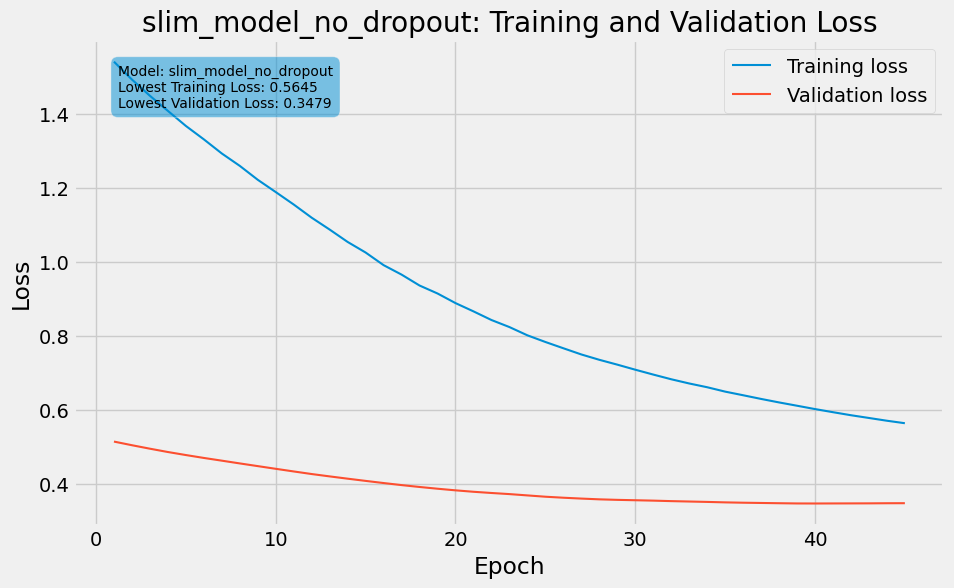

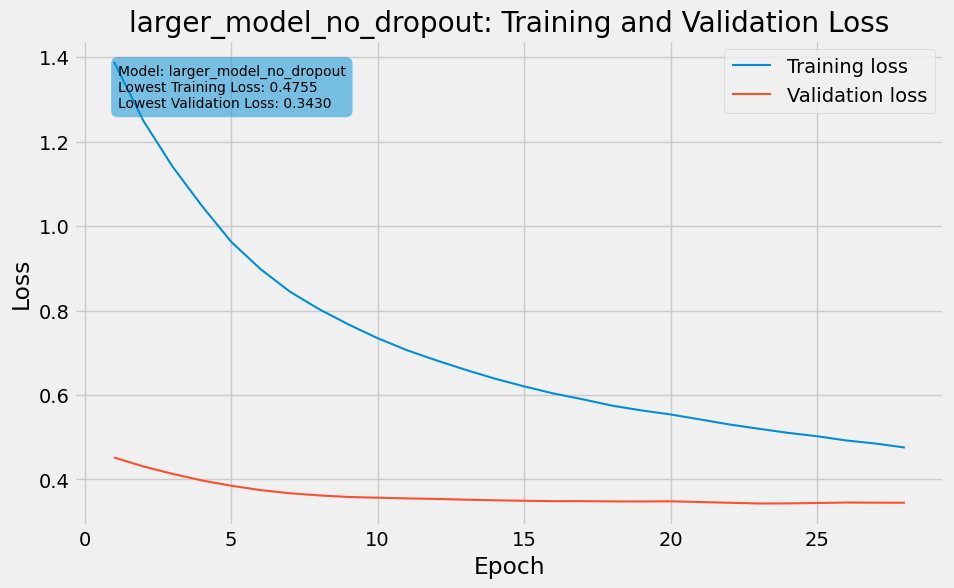

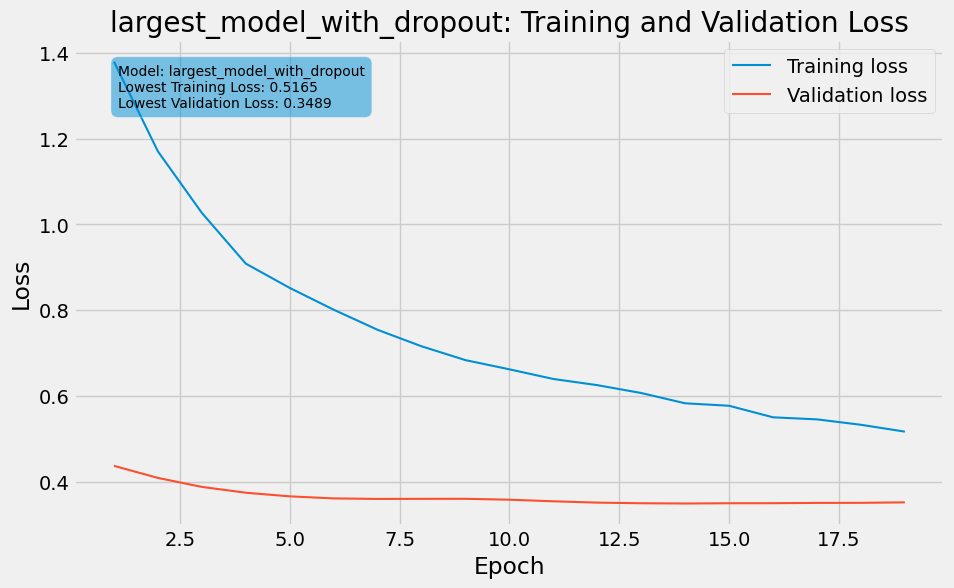

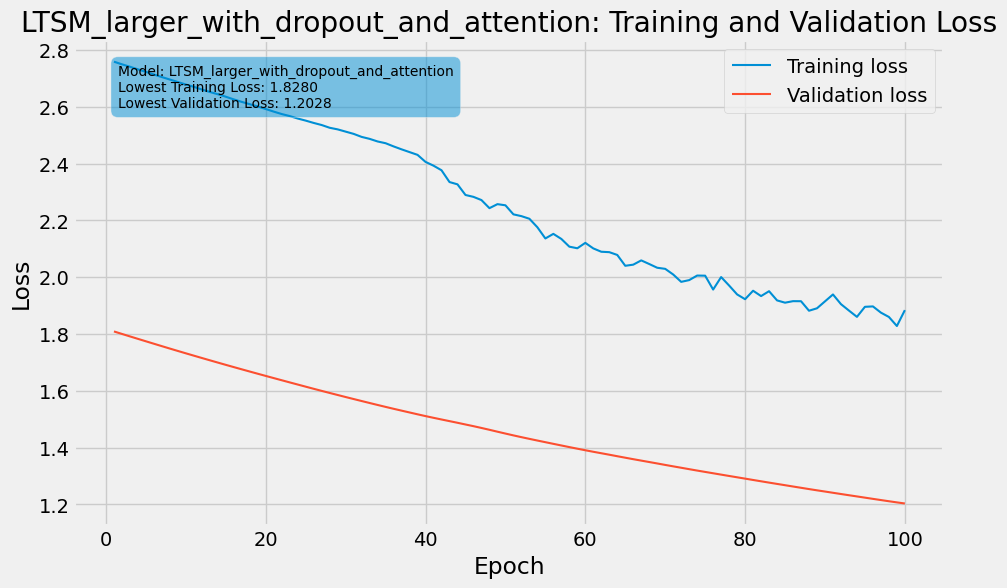

In [ ]:
plt.style.use("fivethirtyeight")
for model, history, model_name in model_histories:
    plot_training_history(history, model_name)

# Predict player performance

Begin predicting the performance of players

In [ ]:
# Preprocess the test data
test_df_preprocessed, _ = preprocess_data(test_df)

# Create sequences for the test data (2023)
test_sequences, test_targets = create_sequences_and_targets(test_df_preprocessed, target_columns, 1)

# Make predictions for 2023
predictions = best_model.predict(test_sequences)

# Compare predictions with actual values
comparison_df = test_df.copy()
comparison_df['Predicted'] = predictions

# Print comparison
print(comparison_df)

# Plot predictions vs actual values
plt.figure(figsize=(10, 6), dpi=100)
plt.plot(comparison_df['Player'], comparison_df[target_columns[0]], 'b-', label='Actual')
plt.plot(comparison_df['Player'], comparison_df['Predicted'], 'r-', label='Predicted')
plt.title('Actual vs Predicted Performance for 2023')
plt.xlabel('Player')
plt.ylabel(target_columns[0])
plt.legend()
plt.show()
